In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
df = pd.read_csv("../../dataset/creditcard.csv")

In [4]:
df.shape

(284807, 31)

In [5]:
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

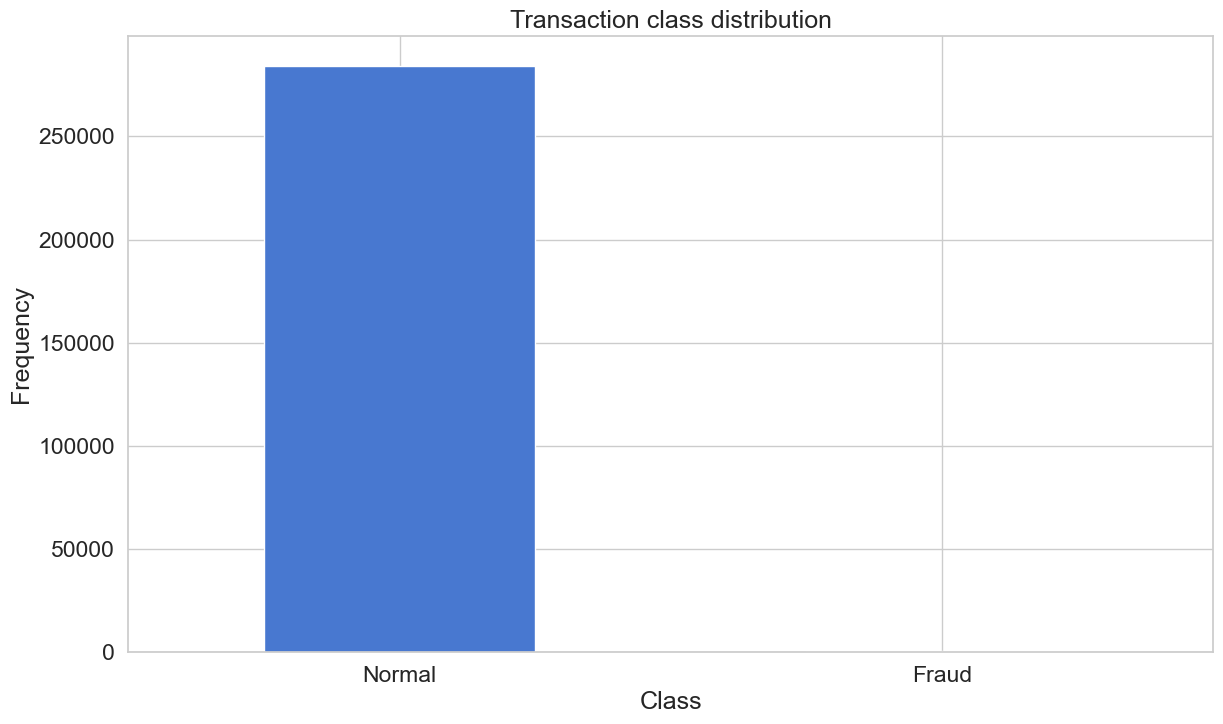

In [6]:
count_classes = pd.value_counts(df["Class"], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [7]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape, normal.shape

((492, 31), (284315, 31))

In [8]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [10]:
from sklearn.preprocessing import StandardScaler

data = df.drop(["Time"], axis=1)
data["Amount"] = StandardScaler().fit_transform(data["Amount"].values.reshape(-1, 1))

In [11]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

X_train, X_val = train_test_split(X_train, test_size=0.33, random_state=RANDOM_SEED)

y_test = X_test["Class"]
X_test = X_test.drop(["Class"], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape, X_val.shape

((152392, 29), (75059, 29))

In [12]:
col = df.columns.drop(["Time", "Amount", "Class"])
col

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

In [19]:
from scipy import stats

def create_dataset(X, time_steps=1, step=1):
    Xs= []
    for i in range(0, len(X) - time_steps, step):
        v = pd.DataFrame(X).iloc[i:(i + time_steps)].values
        Xs.append(v)        
    return np.array(Xs).reshape(-1, time_steps, X.shape[1])

TIME_STEPS = 15
STEP = 1

X_train_cd = create_dataset(X_train, TIME_STEPS,
                                  STEP)
X_test_cd = create_dataset(X_test, TIME_STEPS, STEP)

X_val_cd = create_dataset(X_val, TIME_STEPS, STEP)

print(X_train_cd.shape, X_test_cd.shape, X_val_cd.shape)

(152377, 15, 29) (56947, 15, 29) (75044, 15, 29)


In [21]:
from keras.layers import LSTM, RepeatVector, TimeDistributed

input_dim = X_train_cd.shape[1]
encoding_dim = 14

input_layer = Input(shape=(X_train_cd.shape[1], X_train_cd.shape[2]))
L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(input_layer)
L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
L3 = RepeatVector(X_train_cd.shape[1])(L2)
L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
output = TimeDistributed(Dense(X_train_cd.shape[2]))(L5)    
model = Model(inputs=input_layer, outputs=output)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 29)]          0         
                                                                 
 lstm (LSTM)                 (None, 15, 16)            2944      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 15, 4)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 15, 4)             144       
                                                                 
 lstm_3 (LSTM)               (None, 15, 16)            1344      
                                                             

In [23]:
model.compile(optimizer='adam', loss='mae')

In [24]:
nb_epochs = 10
batch_size = 10
history = model.fit(X_train_cd, X_train_cd, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.33)

Epoch 1/10
10210/10210 [==============================] - 129s 12ms/step - loss: 0.6277 - val_loss: 0.6269
Epoch 2/10
10210/10210 [==============================] - 128s 13ms/step - loss: 0.6222 - val_loss: 0.6225
Epoch 3/10
10210/10210 [==============================] - 128s 13ms/step - loss: 0.6191 - val_loss: 0.6199
Epoch 4/10
10210/10210 [==============================] - 134s 13ms/step - loss: 0.6171 - val_loss: 0.6187
Epoch 5/10
10210/10210 [==============================] - 134s 13ms/step - loss: 0.6158 - val_loss: 0.6181
Epoch 6/10
10210/10210 [==============================] - 134s 13ms/step - loss: 0.6157 - val_loss: 0.6168
Epoch 7/10
10210/10210 [==============================] - 131s 13ms/step - loss: 0.6152 - val_loss: 0.6170
Epoch 8/10
10210/10210 [==============================] - 130s 13ms/step - loss: 0.6146 - val_loss: 0.6168
Epoch 9/10
10210/10210 [==============================] - 137s 13ms/step - loss: 0.6144 - val_loss: 0.6172
Epoch 10/10
10210/10210 [============

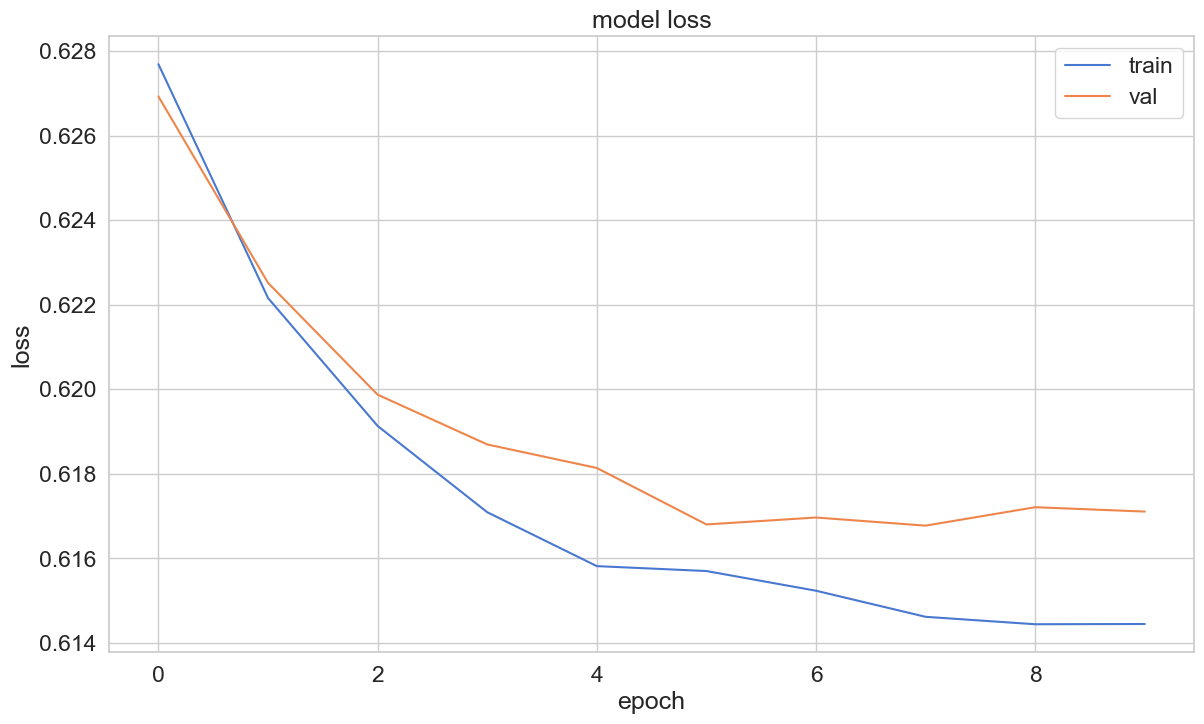

In [26]:
history_obj = history.history
plt.plot(history_obj["loss"])
plt.plot(history_obj["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")

In [30]:
predictions = model.predict(X_test_cd)
mse = np.mean(np.power(X_test_cd - predictions, 2), axis=1)
error_df = pd.DataFrame({"reconstruction_error": mse, "true_class": y_test})
error_df.describe()

1780/1780 [==============================] - 5s 3ms/step


ValueError: Per-column arrays must each be 1-dimensional